# Plotting routine for the Sep22 Event

In [8]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import datetime as datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os
import copy as cp

import py3dcore_h4c as py3dcore_h4c

import fluxplot as fp

import warnings
warnings.filterwarnings('ignore')

#print(sns.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### setting the times for py3DCORE_h4c

In [12]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s = datetime.datetime(2022, 9, 7, 0, 30, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 8, 5, tzinfo=datetime.timezone.utc)

t_fit = [
    datetime.datetime(2022, 9, 7, 2, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 7, 4, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 7, 6, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc)
]

#####2022 Sep 5: 3 solar radii at 17 UT (COR2 & LASCO FoV appearance)
#2022 Sep 5: 15 solar radii at 18:45 UT (PSP)

#### loading fitting results

In [13]:
# specify directory from which to read pickle file (= results of runs)
path = 'solo06092022_heeq_512_4FP/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
respath = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(file) 
        respath.append(os.path.join(path,file))
        print(os.path.join(path, file))     

solo06092022_heeq_512_4FP/00.pickle
solo06092022_heeq_512_4FP/01.pickle
solo06092022_heeq_512_4FP/02.pickle
solo06092022_heeq_512_4FP/03.pickle
solo06092022_heeq_512_4FP/04.pickle
solo06092022_heeq_512_4FP/05.pickle
solo06092022_heeq_512_4FP/06.pickle
solo06092022_heeq_512_4FP/07.pickle
solo06092022_heeq_512_4FP/08.pickle
solo06092022_heeq_512_4FP/09.pickle
solo06092022_heeq_512_4FP/10.pickle
solo06092022_heeq_512_4FP/11.pickle
solo06092022_heeq_512_4FP/12.pickle
solo06092022_heeq_512_4FP/13.pickle


### plotting the results

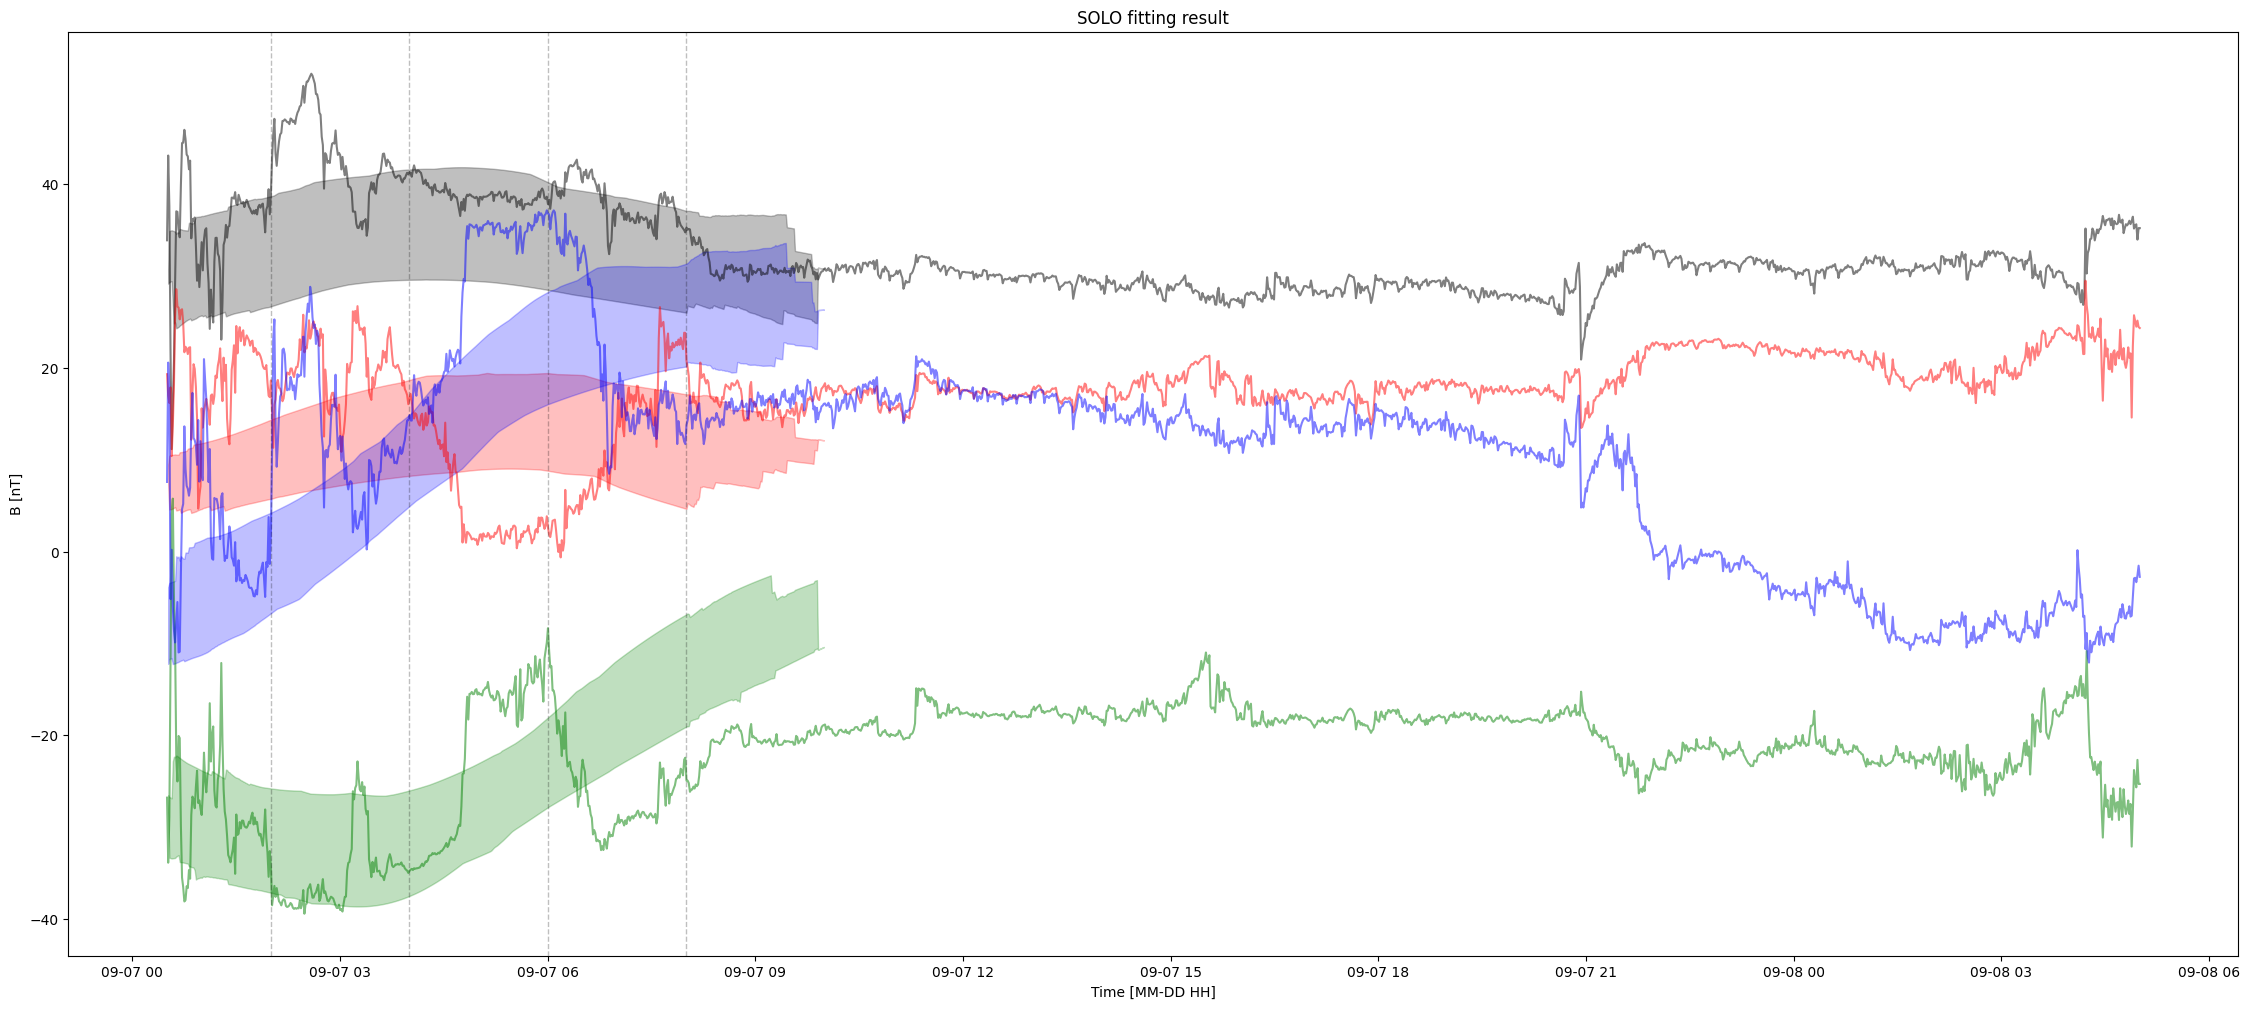

In [21]:
# plot the results 
# get measurements from custom data

from py3dcore_h4c.fitter.base import custom_observer

observer_obj = custom_observer('solo_2022sep.p')

t, b = observer_obj.get([t_s, t_e], "mag", reference_frame="HEEQ", as_endpoints=True)



# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(respath[-1], t, reference_frame="HEEQ", 
                                    reference_frame_to="HEEQ", max_index=128, 
                                    custom_data='solo_2022sep.p')

plt.figure(figsize=(28, 12))
plt.title("SOLO fitting result")
plt.plot(t, np.sqrt(np.sum(b**2, axis=1)), "k", alpha=0.5)
plt.plot(t, b[:, 0], "r", alpha=0.5)
plt.plot(t, b[:, 1], "g", alpha=0.5)
plt.plot(t, b[:, 2], "b", alpha=0.5)
plt.fill_between(t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_fit:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.savefig(path+'%s.png' %resfile[-1])    
plt.show()

In [22]:
ed

[[None,
  None,
  (array([[        nan,         nan,         nan],
          [  9.4673605, -26.542744 ,  -3.8841457],
          [ 10.435981 , -26.731575 ,  -3.4310489],
          ...,
          [        nan,         nan,         nan],
          [        nan,         nan,         nan],
          [        nan,         nan,         nan]], dtype=float32),
   array([[       nan,        nan,        nan],
          [  7.350155, -27.936516, -12.225315],
          [  4.584012, -33.35088 , -11.701146],
          ...,
          [       nan,        nan,        nan],
          [       nan,        nan,        nan],
          [       nan,        nan,        nan]], dtype=float32)),
  (array([      nan, 30.750488, 34.91755 , ...,       nan,       nan,
                nan], dtype=float32),
   array([      nan, 29.181269, 29.352375, ...,       nan,       nan,
                nan], dtype=float32))]]

In [5]:

iparams_arr = np.array([[
    0,      # time offset
    160,    # l_1 (longitude) HEEQ
    0,#-20,    # l_2 (latitude)
    5,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    15,      # r_0 (initialization distance in solar radii)
    1400,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    500,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

In [17]:
overwrite = {
    "cme_longitude": {
            "maximum": 161,
            "minimum": 159
        },
    "cme_latitude": {
            "maximum": 1,
            "minimum": -1
        },
    "cme_inclination" :{
            "maximum": 6,
            "minimum": 4
        },
    "cme_diameter_1au" :{
            "maximum": 0.25,
            "minimum": 0.15
        },
    "cme_aspect_ratio": {
            "maximum": 3.1,
            "minimum": 2.9
        },
    "cme_launch_radius": {
            "distribution": "uniform",
            "maximum": 16,
            "minimum": 14
        },
    "cme_launch_velocity": {
            "maximum": 1425,
            "minimum": 1365
        },
    "t_factor": {
            "maximum": 4.1,
            "minimum": 3.9
        },
    "magnetic_field_strength_1au": {
            "maximum": 56,
            "minimum": 54
        },
    "background_drag": {
            "maximum": 0.6,
            "minimum": 0.4
        },
    "background_velocity": {
            "maximum": 505,
            "minimum": 495
        },
}


In [18]:
n = 1#number of runs

#we initialize model for 1 run with default params

model_obj = py3dcore_h4c.ToroidalModel(t_launch, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [28]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()
#model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1.5)
tm1 =  t_launch + datetime.timedelta(days=1.7)
tm2 =  t_launch + datetime.timedelta(days=3.5)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

In [29]:
############# define synthetic satellite positions - semi-circle at 0.689 AU (SolO), from -180 to +180 longitude

lonstart=-180
lonstep=5
lonend=180

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=0.689
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos[66])

#print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 1.0 AU
satpos2=cp.deepcopy(satpos)
satpos2.r=1.0

(0.689, 150., 0.)


## plot

In [30]:
#model_obj.iparams_arr[0][:]
model_obj.iparams_arr[0][8] = 50

ERROR


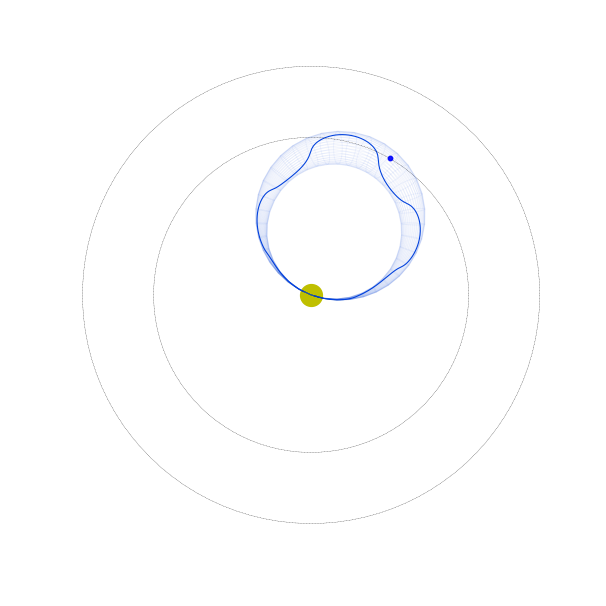

In [31]:
sns.set_context("talk")     

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

fp.plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.8)

fp.plot_3dcore(ax, model_obj, tm0, color=c2)
fp.plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")
fp.plot_satellite(ax,satpos[66],color='blue',alpha=0.9)


# ax.plot([0,0.689],[0,0],[0,0],ls='-',color='black',lw=0.3)

fp.plot_circle(ax,0.689)
fp.plot_circle(ax,1.0)

plt.tight_layout()


#plt.savefig('results/initial_test.pdf')
#plt.savefig('initial_test.png', dpi=100)

ERROR


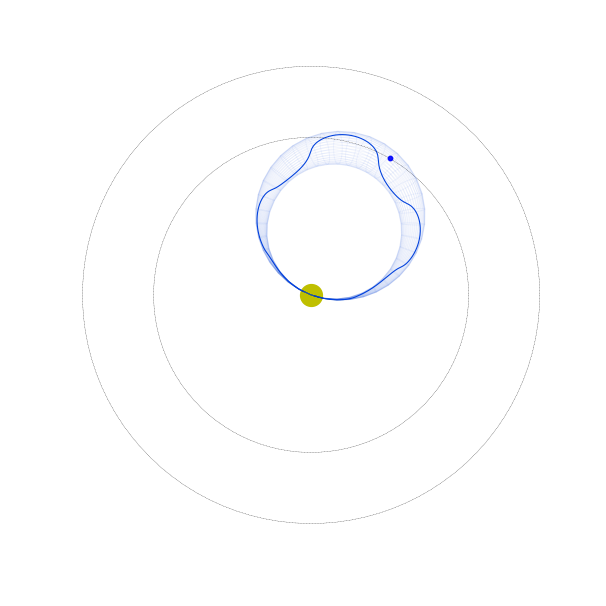

In [33]:

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

fp.plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.8)

fp.plot_3dcore(ax, model_obj, tm0, color=c2)
fp.plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")
fp.plot_satellite(ax,satpos[66],color='blue',alpha=0.9)


# ax.plot([0,0.689],[0,0],[0,0],ls='-',color='black',lw=0.3)

fp.plot_circle(ax,0.689)
fp.plot_circle(ax,1.0)

plt.tight_layout()


#plt.savefig('results/initial_test.pdf')
#plt.savefig('initial_test.png', dpi=100)